In [185]:
import numpy as np
import pandas as pd
import mne
import seaborn as sns
from xml.dom import minidom
import os
from matplotlib import pyplot as plt
from xml.etree import ElementTree

# Load files using one patient as example

### 1. EDF - Signal files in the European Data Format exported from Compumedics Profusion.
### 2. XML (Profusion) - Annotation files exported from Compumedics Profusion. (Learn more...)
### 3. XML (NSRR) - Annotation files processed in the EDF Editor and Translator tool.

### Check out the following websites

## https://sleepdata.org/datasets/shhs/pages/10-montage-and-sampling-rate-information-shhs1.md
## https://github.com/nsrr/edf-editor-translator/wiki/Compumedics-Annotation-Format

In [191]:
patient_id=204841;study='shhs1';

In [3]:
edf_dir=r'C:\Users\ASUS\Documents\school\SleepHeartHealthStudy'

In [4]:
nsr_dir=r'C:\Users\ASUS\Documents\school\SleepHeartHealthStudy'

In [5]:
profusion_dir=r'C:\Users\ASUS\Documents\school\SleepHeartHealthStudy'

In [6]:
study='shhs1'; patient_id=204841;

In [7]:
nsrr_file = os.path.join(edf_dir, study+'-'+str(patient_id)+'-nsrr'+'.xml')

In [184]:
profusion_file = os.path.join(edf_dir, study+'-'+str(patient_id)+'-profusion'+'.xml')

In [62]:
edf_file = os.path.join(edf_dir, study+'-'+str(patient_id)+'.edf')
raw_edf = mne.io.read_raw_edf(edf_file,preload=True, stim_channel='auto', verbose=False)

In [189]:
def nsrr_xml_to_dataframe(nsrr_file):
    tree = ElementTree.parse(nsrr_file)
    root = tree.getroot()

    data_nsrr = pd.DataFrame([])
    for att in root.find('ScoredEvents'):
        try:
            #         print(att.find('ScoredEvent').find('Start').text)
            #     first = att.find('ScoredEvent').text
            #         print("==")
            #         print(att.find('Start').text)
            #         print(att.find('Duration').text)
            #print (att.find('EventType'))

            if att.find('SpO2Nadir') is None:
                SpO2Nadir_entry = np.nan
                SpO2Baseline_entry = np.nan
            else:
                SpO2Nadir_entry = att.find('SpO2Baseline').text
                SpO2Baseline_entry = att.find('SpO2Nadir').text
            data_nsrr = data_nsrr.append([[ 
                                 att.find('EventType').text,
                                 att.find('EventConcept').text, 
                                 att.find('Start').text,
                                 att.find('Duration').text,
                                 att.find('SignalLocation').text,
                                     SpO2Nadir_entry,
                                     SpO2Baseline_entry 
                                ]])

        except Exception as ex:
            pass
    data_nsrr.columns = ['EventConcept', 'EventType','Start','Duration','SignalLocation','SpO2Nadir','SpO2Baseline_entry']

    data_nsrr.reset_index(inplace=True)

    data_nsrr.drop(['index'],axis=1,inplace=True)
    
    return data_nsrr

In [278]:
def profusion_xml_to_dataframe(profusion_file):
    tree = ElementTree.parse(profusion_file)
    root = tree.getroot()

    data = pd.DataFrame([])
    for att in root.find('ScoredEvents'):
        try:
            #         print(att.find('ScoredEvent').find('Start').text)
            #att.find('ScoredEvent').text
            #         print("==")
            #         print(att.find('Start').text)
            #         print(att.find('Duration').text)
            #print (att.find('EventType'))


            data = data.append([[ 
                                 att.find('Name').text,
                                 att.find('Start').text,
                                 att.find('Duration').text,
                                 att.find('Input').text
                                ]])

        except Exception as ex:
            pass

    data.columns = ['Event','Start','Duration','Input']

    data.reset_index(inplace=True)

    data.drop(['index'],axis=1,inplace=True)
    
    sleep_stages = []
    att = root.find('SleepStages')
    for i in range(len(att)):
        sleep_stages.append(int(att[i].text))
    
    return data, sleep_stages


In [279]:
data_nsrr = nsrr_xml_to_dataframe(nsrr_file)

In [280]:
data_profusion, sleep_stages = profusion_xml_to_dataframe(profusion_file)

The whole edf is annoated since 
len(sleep_stages)*30 = 32010s is the edf length

# Exploratory Data Analysis

## data quality for data_nsrr

In [285]:
annotations = data_profusion.merge(data_nsrr,on=['Start','Duration'])

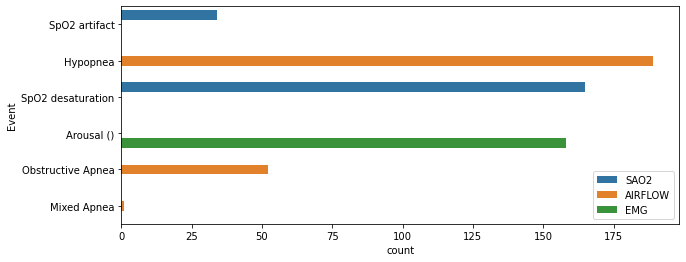

In [375]:
plt.figure(figsize=(10,4))
ax = sns.countplot(y='Event', hue="Input", data=annotations)
plt.legend(loc=4)

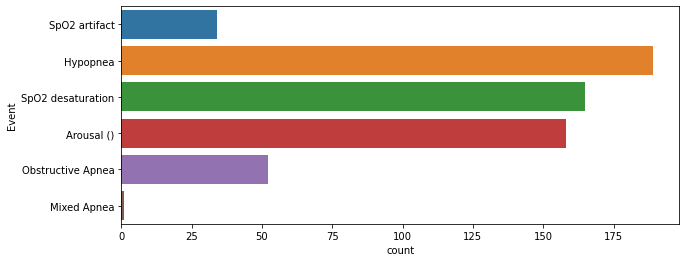

In [377]:
plt.figure(figsize=(10,4))
ax = sns.countplot(y='Event', data=annotations)

## Annotation

In [286]:
annotations

,Event,Start,Duration,Input,EventConcept,EventType,SignalLocation,SpO2Nadir,SpO2Baseline_entry
0,SpO2 artifact,594,3,SAO2,Respiratory|Respiratory,SpO2 artifact|SpO2 artifact,SaO2,NaN,NaN
1,SpO2 artifact,1393,14,SAO2,Respiratory|Respiratory,SpO2 artifact|SpO2 artifact,SaO2,NaN,NaN
2,SpO2 artifact,1501,34,SAO2,Respiratory|Respiratory,SpO2 artifact|SpO2 artifact,SaO2,NaN,NaN
3,SpO2 artifact,1640,12,SAO2,Respiratory|Respiratory,SpO2 artifact|SpO2 artifact,SaO2,NaN,NaN
4,SpO2 artifact,1663,10,SAO2,Respiratory|Respiratory,SpO2 artifact|SpO2 artifact,SaO2,NaN,NaN
...,...,...,...,...,...,...,...,...,...
594,SpO2 artifact,26062,19,SAO2,Respiratory|Respiratory,SpO2 artifact|SpO2 artifact,SaO2,NaN,NaN
595,SpO2 artifact,26123,218,SAO2,Respiratory|Respiratory,SpO2 artifact|SpO2 artifact,SaO2,NaN,NaN
596,SpO2 artifact,26355,19,SAO2,Respiratory|Respiratory,SpO2 artifact|SpO2 artifact,SaO2,NaN,NaN
597,SpO2 artifact,26387,8,SAO2,Respiratory|Respiratory,SpO2 artifact|SpO2 artifact,SaO2,NaN,NaN


In [363]:
my_annot = mne.Annotations(onset=annotations['Start'],  # in seconds
                           duration=annotations['Duration'],  # in seconds, too
                           description=annotations['Event'])

In [364]:
Epoch_length = 30;

In [365]:
Sleep_annotation = mne.Annotations(onset=np.array(range(len(sleep_stages)))*Epoch_length,  # in seconds
                           duration=np.ones(len(sleep_stages))*Epoch_length,  # in seconds, too
                           description=sleep_stages)

## Plot the hypnogram 

C:\Users\ASUS\AppData\Local\Temp/ipykernel_2560/1989580701.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(y_label_list)


Text(0.5, 1.0, 'Hypnogram for Patient: 204841')

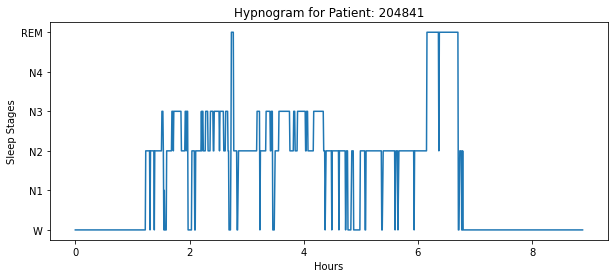

In [366]:
fig, ax = plt.subplots(figsize=(10,4))

ax.plot(np.array(range(len(sleep_stages)))*Epoch_length/3600 ,sleep_stages )
y_label_list = ['','W', 'N1', 'N2' , 'N3', 'N4', 'REM']
ax.set_yticklabels(y_label_list)
ax.set_xlabel('Hours')
ax.set_ylabel('Sleep Stages')
ax.set_title('Hypnogram for Patient: '+str(patient_id))

## Summary of the PSG data

In [367]:
print('Data type: {}\n\n{}\n'.format(type(raw_edf), raw_edf))
# print('{} \n'.format(raw))

# Get the sample rate
print('Sample rate:', raw_edf.info['sfreq'], 'Hz')

# Get the size of the matrix
print('Size of the matrix: {}\n'.format(raw_edf.get_data().shape))

# We can use the mne.info class to learn moure about the data.
print(raw_edf.info)

Data type: <class 'mne.io.edf.edf.RawEDF'>

<RawEDF | shhs1-204841.edf, 15 x 4001250 (32010.0 s), ~457.9 MB, data loaded>

Sample rate: 125.0 Hz
Size of the matrix: (15, 4001250)

<Info | 7 non-empty values
 bads: []
 ch_names: SaO2, H.R., EEG(sec), ECG, EMG, EOG(L), EOG(R), EEG, SOUND, THOR ...
 chs: 15 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 62.5 Hz
 meas_date: 1985-01-01 21:30:00 UTC
 nchan: 15
 projs: []
 sfreq: 125.0 Hz
>


shhs1 (Visit 1) -- the baseline clinic visit and polysomnogram performed between 1995 and 1998
5,804 rows, down from the original 6,441 due to data sharing rules on certain cohorts and subject

## Is the PSG data raw or already processes? Does it need a high pass filter?

In [370]:
raw_edf.set_annotations(my_annot + Sleep_annotation)
print(raw_edf.annotations)

<Annotations | 1666 segments: 0 (464), 1 (10), 2 (373), 3 (150), 5 (70), ...>


## Example plot

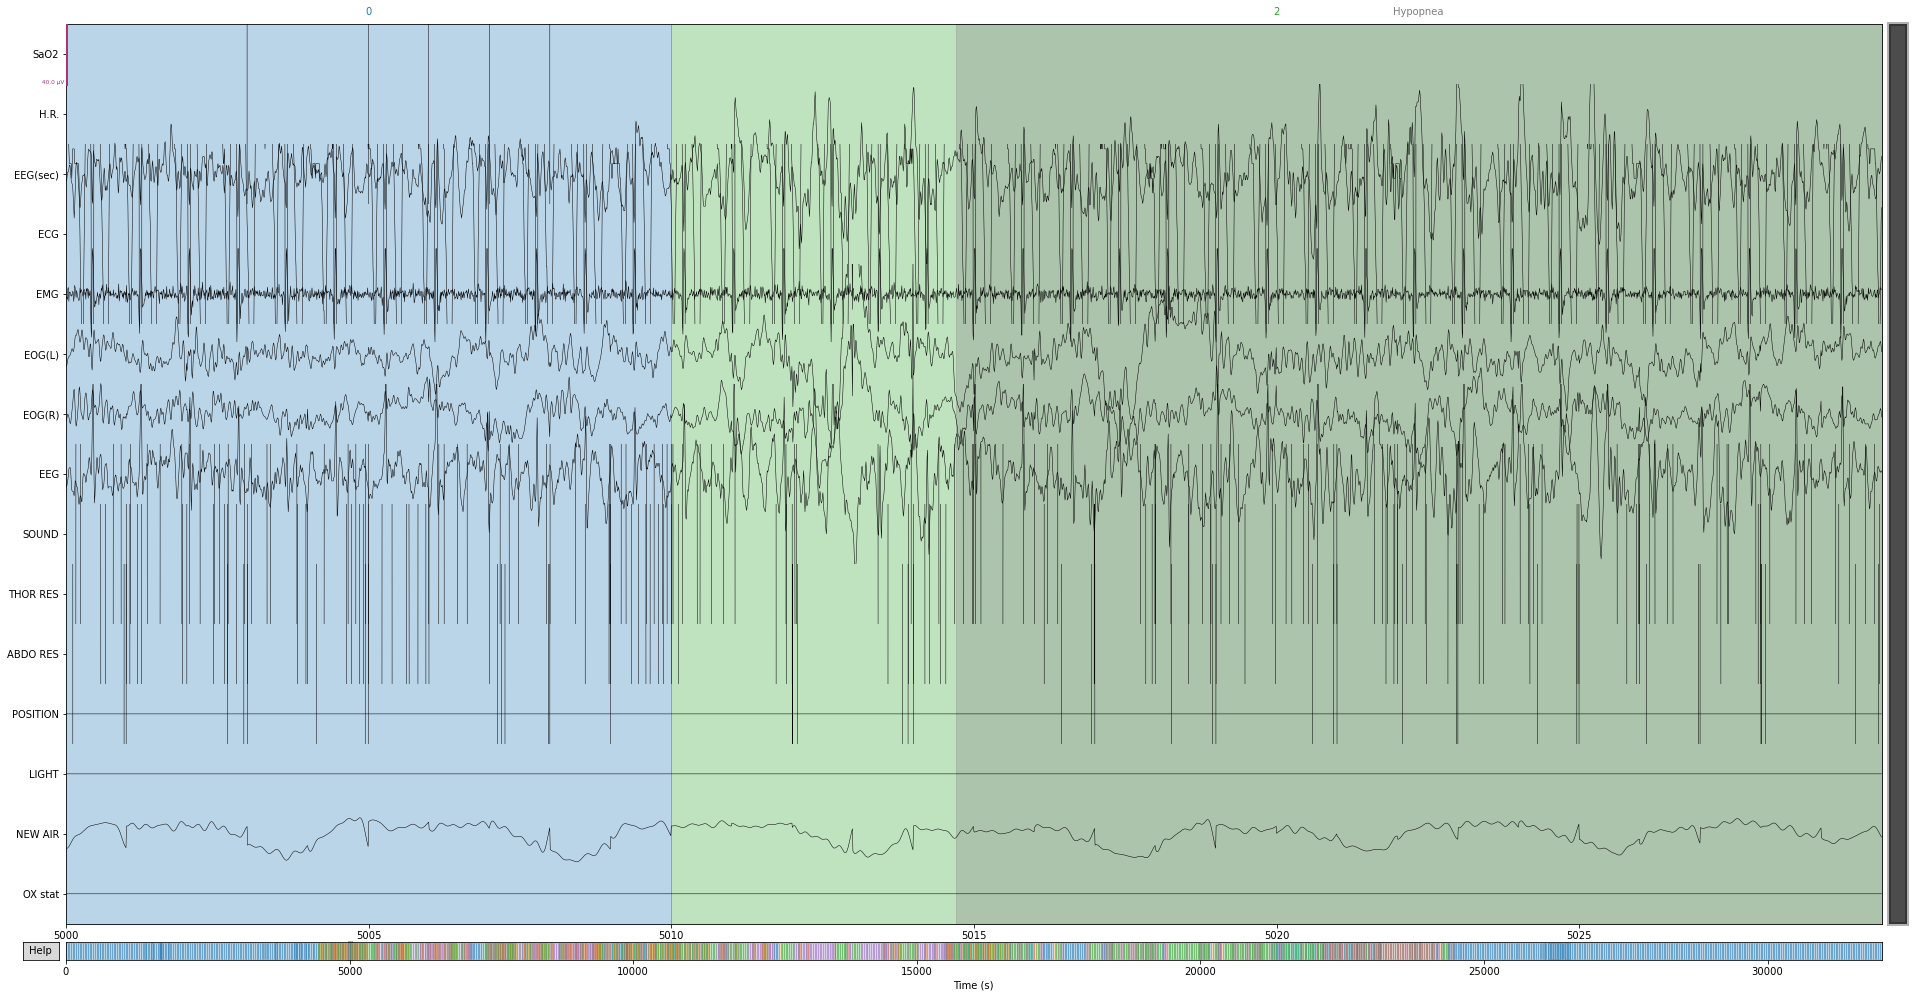

In [372]:
fig = raw_edf.plot(start=5000, duration=30)

C:\Users\ASUS\AppData\Local\Temp/ipykernel_2560/347893108.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_edf.plot_psd(tmax=np.inf, fmax=50)


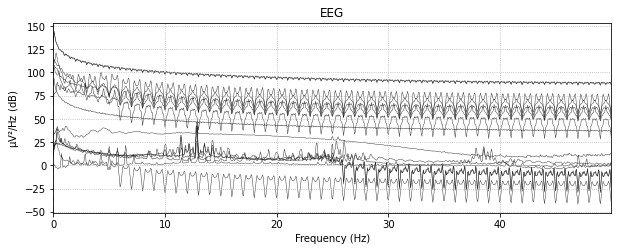

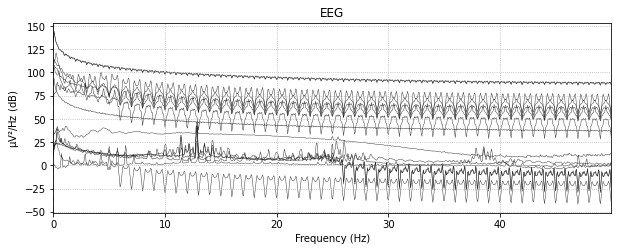

In [373]:
raw_edf.plot_psd(tmax=np.inf, fmax=50)

In [374]:
raw_edf.annotations.save('annotations-'+str(patient_id)+'.csv', overwrite=True)